[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Training MSE: 0.0006
Training MSE Std Dev: 0.0004
Test MSE: 0.0012
Test MSE Std Dev: 0.0012
Training RMSE: 0.0212
Training RMSE Std Dev: 0.0119
Test RMSE: 0.0293
Test RMSE Std Dev: 0.0171
Training MAE: 0.0151
Training MAE Std Dev: 0.0087
Test MAE: 0.0219
Test MAE Std Dev: 0.0129
Training R2: 0.8319
Training R2 Std Dev: 0.1048
Test R2: 0.7537
Test R2 Std Dev: 0.1497


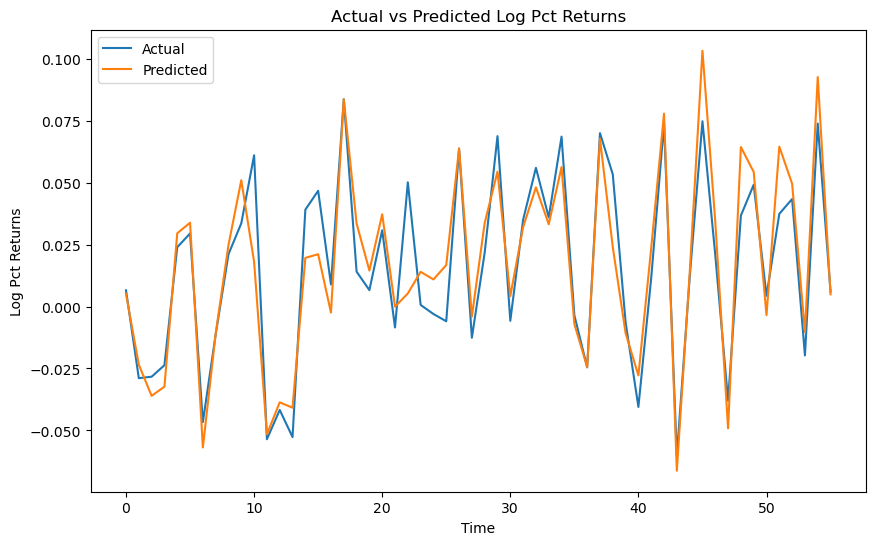

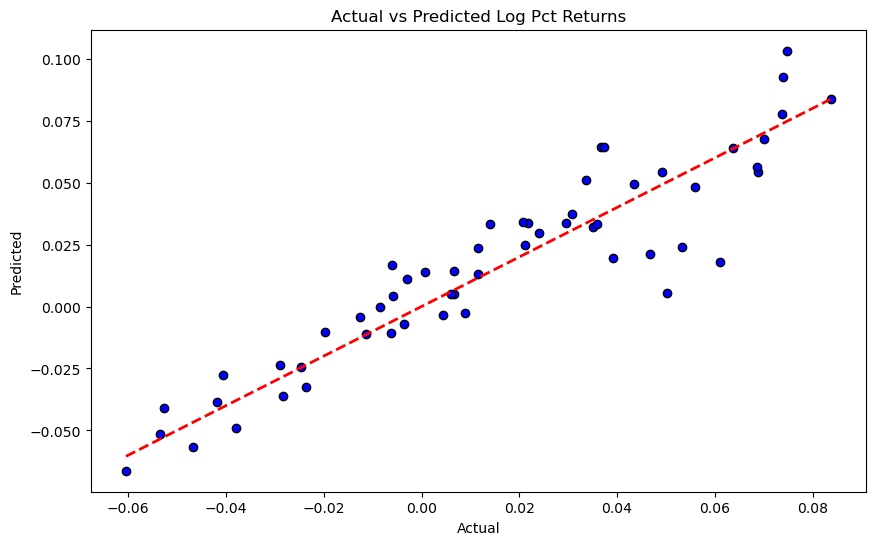

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download stock price data from Yahoo Finance using ticker 'COIN'
ticker = 'COIN'
data_coin = yf.download(tickers=ticker, start=start_date, end=end_date)
df_coin = pd.DataFrame(data_coin)
df_coin.reset_index(inplace=True)
df_coin.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_coin['Gold_Adj_Close'] = df_gold['Adj Close']
df_coin['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_coin = df_coin.ffill()

# Calculate differences between open, high, low, and adjusted close prices for the stock data
df_coin['Open_Close_Diff'] = df_coin['Open'] - df_coin['Adj Close']
df_coin['High_Low_Diff'] = df_coin['High'] - df_coin['Low']

# Calculate percentage returns and log percentage returns
df_coin['Pct_Returns'] = df_coin['Adj Close'].pct_change()
df_coin['Log_Pct_Returns'] = np.log(1 + df_coin['Pct_Returns'])
df_coin.dropna(inplace=True)

# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
     'Open_Close_Diff', 'High_Low_Diff', 
     'Gold_Adj_Close', 'USIndex_Adj_Close'
]

# Number of lagged versions to create
num_lags = 3  

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin['Pct_Returns_1'] = df_coin['Pct_Returns'].shift(1)
df_coin['Log_Pct_Returns_1'] = df_coin['Log_Pct_Returns'].shift(1)

df_coin.dropna(inplace=True)

# Moving Averages
# Simple Moving Averages
df_coin['SMA_5'] = df_coin['Adj Close'].rolling(window=5).mean()
df_coin['SMA_10'] = df_coin['Adj Close'].rolling(window=10).mean()
df_coin['SMA_20'] = df_coin['Adj Close'].rolling(window=20).mean()
df_coin['SMA_50'] = df_coin['Adj Close'].rolling(window=50).mean()

# Exponential Moving Averages
df_coin['EMA_50'] = df_coin['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_coin['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_coin['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_coin['MACD'] = df_coin['Adj Close'].ewm(span=12, adjust=False).mean() - df_coin['Adj Close'].ewm(span=26, adjust=False).mean()
df_coin['MACD_Signal'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
df_coin['MACD_Hist'] = df_coin['MACD'] - df_coin['MACD_Signal']

# Bollinger Bands
df_coin['BB_Upper'] = df_coin['SMA_20'] + 2*df_coin['Adj Close'].rolling(window=20).std()
df_coin['BB_Lower'] = df_coin['SMA_20'] - 2*df_coin['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_coin['14-high'] = df_coin['High'].rolling(14).max()
df_coin['14-low'] = df_coin['Low'].rolling(14).min()
df_coin['%K'] = (df_coin['Adj Close'] - df_coin['14-low']) * 100 / (df_coin['14-high'] - df_coin['14-low'])
df_coin['%D'] = df_coin['%K'].rolling(3).mean()

# Average True Range (ATR)
df_coin['H-L'] = df_coin['High'] - df_coin['Low']
df_coin['H-PC'] = np.abs(df_coin['High'] - df_coin['Adj Close'].shift(1))
df_coin['L-PC'] = np.abs(df_coin['Low'] - df_coin['Adj Close'].shift(1))
df_coin['TR'] = df_coin[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_coin['ATR'] = df_coin['TR'].rolling(14).mean()

# List of columns to shift
columns_to_shift = [
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR'
]

# Number of lagged versions to create
num_lags = 2

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin.dropna(inplace=True)

# Fetch economic indicators
# Fetch inflation rate data(Daily) from FRED using pandas_datareader
Inflation_df = pdr.get_data_fred('T5YIE', start=start_date, end=end_date)
Inflation_df.ffill()
Inflation_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Inflation_df.index = pd.to_datetime(Inflation_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_coin.join(Inflation_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)

# Define the features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
             'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
             'Open_3',  'Low_3',
             'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
             'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

# Perform cross-validation with SARIMAX
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit SARIMAX model
    model = SARIMAX(y_train, exog=X_train, order=(0, 0, 1), seasonal_order= (1, 0, 0, 12))
    model_fit = model.fit(disp=False)
    
    # Predict on the test set
    y_train_pred = model_fit.predict(start=train_index[0], end=train_index[-1], exog=X_train)
    y_test_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)
    
    # Align the index of the predictions with the actual values
    y_train_pred.index = y_train.index
    y_test_pred.index = y_test.index
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred.values, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()


p (autoregressive order): Number of lag observations included in the model (can be 0, 1, or higher).

d (differencing order): Number of times the raw observations are differenced (typically 0 or 1 to remove trends).

q (moving average order): Number of lagged forecast errors in the prediction equation (typically 0 or 1).

P (seasonal autoregressive order): Seasonal equivalent of p.

D (seasonal differencing order): Seasonal equivalent of d.

Q (seasonal moving average order): Seasonal equivalent of q.

s (seasonal period): Length of the seasonal cycle (e.g., 12 for monthly data).

Units (50, 100, 150): These values are chosen to explore a range of model complexities from simpler (50 units) to more complex (150 units). It's common to start with these values to understand how the model performs with different levels of complexity.

Dropout Rate (0.2, 0.3, 0.4): Dropout rates within this range are typically effective at preventing overfitting without severely impacting the learning capability of the model. They provide a balance between underfitting (too high dropout) and overfitting (too low dropout).

Epochs (10, 20, 30): This range is chosen to explore different lengths of training. Fewer epochs might not fully train the model, while too many epochs might overfit. These values provide a balance to determine the optimal training duration.

Batch Size (16, 32, 64): These are common batch sizes that offer a balance between training stability and efficiency. Smaller batches provide more stable updates but can be computationally intensive, while larger batches are more efficient but can result in noisier updates.

predict adjusted closing prices, adjusted close prices - current return. no shifting lg percentage return. 

Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1'
'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'RSI_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1'
'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE',
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS'

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download stock price data from Yahoo Finance using ticker 'COIN'
ticker = 'COIN'
data_coin = yf.download(tickers=ticker, start=start_date, end=end_date)
df_coin = pd.DataFrame(data_coin)
df_coin.reset_index(inplace=True)
df_coin.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_coin['Gold_Adj_Close'] = df_gold['Adj Close']
df_coin['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_coin = df_coin.ffill()

# Calculate differences between open, high, low, and adjusted close prices for the stock data
df_coin['Open_Close_Diff'] = df_coin['Open'] - df_coin['Adj Close']
df_coin['High_Low_Diff'] = df_coin['High'] - df_coin['Low']

# Calculate percentage returns and log percentage returns
df_coin['Pct_Returns'] = df_coin['Adj Close'].pct_change()
df_coin['Log_Pct_Returns'] = np.log(1 + df_coin['Pct_Returns'])
df_coin.dropna(inplace=True)

# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
     'Open_Close_Diff', 'High_Low_Diff', 
     'Gold_Adj_Close', 'USIndex_Adj_Close'
]

# Number of lagged versions to create
num_lags = 3  

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

# Moving Averages
# Simple Moving Averages
df_coin['SMA_5'] = df_coin['Adj Close'].rolling(window=5).mean()
df_coin['SMA_10'] = df_coin['Adj Close'].rolling(window=10).mean()
df_coin['SMA_20'] = df_coin['Adj Close'].rolling(window=20).mean()
df_coin['SMA_50'] = df_coin['Adj Close'].rolling(window=50).mean()

# Exponential Moving Averages
df_coin['EMA_50'] = df_coin['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_coin['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_coin['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_coin['MACD'] = df_coin['Adj Close'].ewm(span=12, adjust=False).mean() - df_coin['Adj Close'].ewm(span=26, adjust=False).mean()
df_coin['MACD_Signal'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
df_coin['MACD_Hist'] = df_coin['MACD'] - df_coin['MACD_Signal']

# Bollinger Bands
df_coin['BB_Upper'] = df_coin['SMA_20'] + 2*df_coin['Adj Close'].rolling(window=20).std()
df_coin['BB_Lower'] = df_coin['SMA_20'] - 2*df_coin['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_coin['14-high'] = df_coin['High'].rolling(14).max()
df_coin['14-low'] = df_coin['Low'].rolling(14).min()
df_coin['%K'] = (df_coin['Adj Close'] - df_coin['14-low']) * 100 / (df_coin['14-high'] - df_coin['14-low'])
df_coin['%D'] = df_coin['%K'].rolling(3).mean()

# Average True Range (ATR)
df_coin['H-L'] = df_coin['High'] - df_coin['Low']
df_coin['H-PC'] = np.abs(df_coin['High'] - df_coin['Adj Close'].shift(1))
df_coin['L-PC'] = np.abs(df_coin['Low'] - df_coin['Adj Close'].shift(1))
df_coin['TR'] = df_coin[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_coin['ATR'] = df_coin['TR'].rolling(14).mean()

# List of columns to shift
columns_to_shift = [
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR'
]

# Number of lagged versions to create
num_lags = 2

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin.dropna(inplace=True)

# Fetch economic indicators
# Fetch inflation rate data(Daily) from FRED using pandas_datareader
Inflation_df = pdr.get_data_fred('T5YIE', start=start_date, end=end_date)
Inflation_df.ffill()
Inflation_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Inflation_df.index = pd.to_datetime(Inflation_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_coin.join(Inflation_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)

# Define the features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','High_Low_Diff_1', 
            'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1', 'EMA_50_1', 'RSI_1', 
            'MACD_1', 'MACD_Signal_1', 'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', 
            '%K_1', '%D_1','ATR_1',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS']
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Define the hyperparameter grid for SARIMAX
p = d = q = range(0, 2)
seasonal_pdq = list(itertools.product(p, d, q, [12]))  # We use a seasonal period of 12 for monthly data

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

# Perform hyperparameter tuning with SARIMAX
best_aic = np.inf
best_params = None

for param in seasonal_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            aic = 0
            for train_index, test_index in tscv.split(X_scaled):
                X_train, X_test = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                # Fit SARIMAX model
                model = SARIMAX(y_train, exog=X_train, order=param[:3], seasonal_order=param_seasonal)
                model_fit = model.fit(disp=False)
                
                # Calculate AIC
                aic += model_fit.aic

            # Average AIC across splits
            aic /= tscv.n_splits
            
            if aic < best_aic:
                best_aic = aic
                best_params = (param, param_seasonal)
        except:
            continue

print(f"Best SARIMAX configuration: {best_params} with AIC: {best_aic}")

# Perform cross-validation with the best SARIMAX model
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit SARIMAX model with the best parameters
    model = SARIMAX(y_train, exog=X_train, order=best_params[0], seasonal_order=best_params[1])
    model_fit = model.fit(disp=False)
    
    # Predict on the test set
    y_train_pred = model_fit.predict(start=train_index[0], end=train_index[-1], exog=X_train)
    y_test_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)
    
    # Align the index of the predictions with the actual values
    y_train_pred.index = y_train.index
    y_test_pred.index = y_test.index
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_test_r2_scores)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred.values, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


KeyError: "['DSPIC96'] not in index"